# Data Ingestion and BERT Preparation

# A. Environment Setup

In [1]:
import pandas as pd
import numpy as np
import nltk
import sklearn

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import io
import os
import math
import zipfile
import time

from tqdm import tqdm
from pprint import pprint

# Suppress new window for plots
%matplotlib inline 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, cross_val_score

In [3]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
from google.colab import files, drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import gc
gc.collect() # Force garbage collector to release unreferenced memory
!ls

drive		  test_dataset_bars.png   train_orig_bars.png
lsvc_orig_cm.png  test_orig_bars.png
sample_data	  train_dataset_bars.png


# B. Functions

In [0]:
def plot_cm(y_true, y_pred, filename, figsize=(10,8)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    fig, ax = plt.subplots(figsize=figsize)
    colormap = sns.diverging_palette(220, 20, sep=20, as_cmap=True) #plt.cm.coolwarm #coolwarm_r reverse
    sns.heatmap(cm, 
                cmap=colormap, 
                annot=annot, 
                annot_kws={"size": 12}, 
                fmt='',
                linewidths=1, 
                square=True, 
                ax=ax)
    ax.set_title('Confusion Matrix\n', fontsize=16, weight='bold');
    ax.set_xlabel('\n\nPredicted Label', fontsize=12);
    ax.set_ylabel('Actual Label\n\n', fontsize=12);
    plt.savefig(filename + '_cm.png', bbox_inches='tight')
    return

In [0]:
def plt_barchart(df, title, filename):
  sns.set_style("white")

  df2 = df.groupby('PriorityID').agg({'PriorityID':['count']}).reset_index()
  df2.columns = ['PriorityID', 'count']
  df2['pct'] = df2['count']*100/(sum(df2['count']))

  x = df2['PriorityID']
  y = df2['pct']

  palette = ['red','orange', 'green', 'yellow']

  fig, ax = plt.subplots(figsize = (8,4))
  fig = sns.barplot(y, x, estimator = sum, ci = None, orient='h', palette=palette)

  for i, v in enumerate(y):
    ax.text(v+1, i+.05, str(round(v,3))+'%', color='black', fontweight='bold')

  ax.set(xlim=(0,100))
  plt.title(title + '\nTicket Priority as Percentage of Total', size=16, weight='bold')
  plt.ylabel('Ticket Priority')
  plt.xlabel('% Total');
  plt.savefig(filename + '_bars.png')
  return

In [0]:
def prt_counts(df, title):
  df2 = df.groupby('PriorityID').agg({'PriorityID':['count']}).reset_index()
  df2.columns = ['PriorityID', 'count']
  print(title)
  print("-"*20)
  print(df2)
  print("-"*20)
  total = df2["count"].sum()
  print("Total count = ", total)
  print()
  return

In [0]:
def plot_history(history, string, filename):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  plt.savefig(filename + '_history.png')
  return

## B.4 Utility Functions

In [0]:
def releaseDF(df):
    '''
    Release dataframe from memory
    '''
    list_df = [df]
    del list_df
    return

# C. Import Pre-Processed Dataset

## C.1 Import Raw Dataset

In [0]:
path_to_data = "/content/drive/My Drive/Colab Notebooks/W266 Final Project/data/"
path_to_img = "/content/drive/My Drive/Colab Notebooks/W266 EBP/"

filename_in = "dataset.csv"
filename_img = "results_orig"

img_path = path_to_img + filename_img

#filename_in = "ebp_balanced_undersampled.csv"

In [0]:
dataset = pd.read_csv(path_to_data + filename_in, dtype = {'Notes': str})

In [13]:
print(dataset.shape)
print(dataset.isnull().values.any())
print()
dataset.isnull().any()

(24199, 8)
True



Unnamed: 0       False
PriorityID       False
label            False
text              True
label_pr_low     False
label_pr_norm    False
label_pr_high    False
label_pr_crit    False
dtype: bool

In [14]:
print(dataset.isnull().T.any().T.sum()) # Number of rows with NaNs
print()
dataset[pd.isnull(dataset).any(axis=1)]

1



,Unnamed: 0,PriorityID,label,text,label_pr_low,label_pr_norm,label_pr_high,label_pr_crit
3786,3786,Normal,1,NaN,0,1,0,0


In [0]:
dataset = dataset.dropna(how="any")
dataset.reset_index(inplace=True, drop=True)

In [16]:
print(dataset.shape)
print(dataset.isnull().values.any())

(24198, 8)
False


In [17]:
dataset.head(5)

,Unnamed: 0,PriorityID,label,text,label_pr_low,label_pr_norm,label_pr_high,label_pr_crit
0,0,Normal,1,created,0,1,0,0
1,1,Normal,1,efp auto ticket action error while handli...,0,1,0,0
2,2,Normal,1,this seems to be stuck on submitting,0,1,0,0
3,3,Normal,1,submitted,0,1,0,0
4,4,Normal,1,closing,0,1,0,0


In [18]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24198 entries, 0 to 24197
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     24198 non-null  int64 
 1   PriorityID     24198 non-null  object
 2   label          24198 non-null  int64 
 3   text           24198 non-null  object
 4   label_pr_low   24198 non-null  int64 
 5   label_pr_norm  24198 non-null  int64 
 6   label_pr_high  24198 non-null  int64 
 7   label_pr_crit  24198 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 1.5+ MB


# D. Modeling Using LSVC

In [0]:
tfidf = TfidfVectorizer(sublinear_tf=True, 
                        min_df=5, 
                        norm='l2', 
                        encoding='latin-1', 
                        ngram_range=(1, 3))

In [20]:
features = tfidf.fit_transform(dataset.text).toarray()
labels = dataset.label.values
print(features.shape)

(24198, 69994)


In [21]:
x_train, x_test, y_train, y_test, idx_train, idx_test = train_test_split(features,  
                                                                         labels,
                                                                         dataset.index,
                                                                         test_size=0.2, 
                                                                         shuffle=True,
                                                                         random_state=273)
print("train shape: ", x_train.shape)
print("test shape:  ", x_test.shape)

train shape:  (19358, 69994)
test shape:   (4840, 69994)


In [0]:
clf_lsvc = LinearSVC()
clf_lsvc.fit(x_train, y_train)
y_pred = clf_lsvc.predict(x_test)

              precision    recall  f1-score   support

     Low (0)     0.8235    0.2897    0.4286       145
  Normal (1)     0.9015    0.9766    0.9375      4096
    High (2)     0.7411    0.4308    0.5449       578
Critical (3)     0.9375    0.7143    0.8108        21

    accuracy                         0.8897      4840
   macro avg     0.8509    0.6028    0.6804      4840
weighted avg     0.8802    0.8897    0.8748      4840



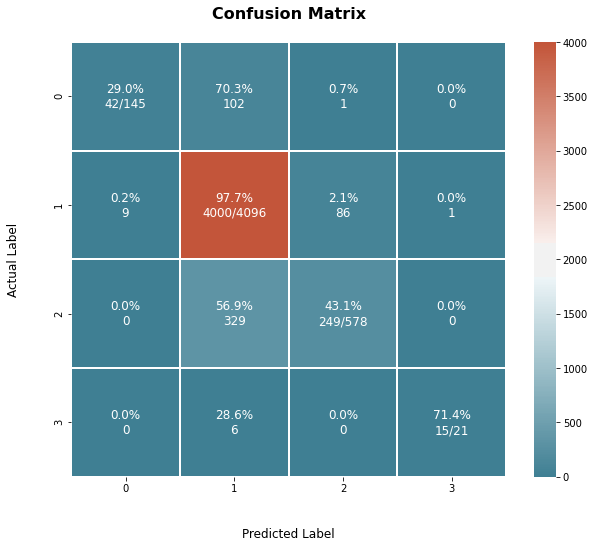

In [23]:
print(metrics.classification_report(y_test, 
                                    y_pred, 
                                    target_names=["Low (0)","Normal (1)","High (2)","Critical (3)"],
                                    digits=4))
plot_cm(y_test, y_pred, img_path)